# Neural Matrix Factorization (NeuMF)

This notebook implements **Neural Matrix Factorization (NeuMF)** from the paper ["Neural Collaborative Filtering"](https://arxiv.org/abs/1708.05031) (He et al., 2017) using PyTorch.

## Overview

NeuMF combines two complementary approaches:

1. **Generalized Matrix Factorization (GMF)**: A neural interpretation of traditional MF that captures linear user-item interactions through element-wise product of embeddings.

2. **Multi-Layer Perceptron (MLP)**: A deep neural network that learns non-linear, higher-order interactions from concatenated user-item embeddings.

### Architecture

```
User ID ──► User Embedding (GMF) ─┐
                                  ├─► Element-wise Product ─┐
Item ID ──► Item Embedding (GMF) ─┘                         │
                                                            ├─► Concat ─► Output ─► ŷ
User ID ──► User Embedding (MLP) ─┐                         │
                                  ├─► Concat ─► MLP Layers ─┘
Item ID ──► Item Embedding (MLP) ─┘
```

### Key Concepts

- **Separate Embeddings**: GMF and MLP use different embedding spaces, allowing each component to learn optimal representations for its purpose.
- **Implicit Feedback**: We treat ratings ≥ 4 as positive interactions (binary classification).
- **Negative Sampling**: For each positive interaction, we sample negative (non-interacted) items for training.

## 1. Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict
from typing import List, Set, Dict, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.sparse import csr_matrix
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reproducibility
SEED = 2025
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Load MovieLens 100K Dataset

In [3]:
# Load MovieLens 100K
DATA_PATH = "/Users/codexplore/Developer/repos/recommender-system/data/movielens/ml-100k/u.data"
cols = ["user", "item", "rating", "timestamp"]
df = pd.read_csv(DATA_PATH, sep="\t", names=cols)

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique():,}")
print(f"Unique items: {df['item'].nunique():,}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
df.head()

Total interactions: 100,000
Unique users: 943
Unique items: 1,682
Rating range: 1 - 5


,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# Convert to implicit feedback: rating >= 4 is positive interaction
df["interaction"] = (df["rating"] >= 4).astype(int)
df_implicit = df[df["interaction"] == 1].copy()

print(f"Positive interactions (rating >= 4): {len(df_implicit):,}")
print(f"Sparsity: {1 - len(df_implicit) / (df['user'].nunique() * df['item'].nunique()):.4%}")

Positive interactions (rating >= 4): 55,375
Sparsity: 96.5088%


In [5]:
# Create 0-based user and item indices
user2id = {u: i for i, u in enumerate(df_implicit["user"].unique())}
item2id = {i: j for j, i in enumerate(df_implicit["item"].unique())}
id2user = {i: u for u, i in user2id.items()}
id2item = {j: i for i, j in item2id.items()}

df_implicit["uid"] = df_implicit["user"].map(user2id)
df_implicit["iid"] = df_implicit["item"].map(item2id)

n_users = len(user2id)
n_items = len(item2id)

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")

Number of users: 942
Number of items: 1447


## 3. Train/Validation/Test Split

We use **temporal leave-one-out** splitting:
- For each user, sort interactions by timestamp
- Last interaction → Test set
- Second-to-last interaction → Validation set  
- All other interactions → Training set

In [6]:
train_data = []
val_data = []
test_data = []

# User interaction history for negative sampling
user_pos_items = defaultdict(set)

for uid, hist in df_implicit.groupby("uid"):
    hist = hist.sort_values("timestamp")
    items = hist["iid"].tolist()
    
    if len(items) < 3:
        # Not enough interactions for train/val/test split
        continue
    
    # Store all positive items for this user
    user_pos_items[uid] = set(items)
    
    # Split: all but last 2 for train, second-to-last for val, last for test
    train_items = items[:-2]
    val_item = items[-2]
    test_item = items[-1]
    
    for iid in train_items:
        train_data.append((uid, iid))
    val_data.append((uid, val_item))
    test_data.append((uid, test_item))

print(f"Train interactions: {len(train_data):,}")
print(f"Validation users: {len(val_data):,}")
print(f"Test users: {len(test_data):,}")

Train interactions: 53,491
Validation users: 942
Test users: 942


In [7]:
# Build training interaction matrix (for filtering during evaluation)
train_df = pd.DataFrame(train_data, columns=["uid", "iid"])
train_df.head()

,uid,iid
0,0,172
1,0,95
2,0,264
3,0,61
4,0,115


In [9]:
R_train = csr_matrix(
    (np.ones(len(train_df)), (train_df["uid"], train_df["iid"])),
    shape=(n_users, n_items)
)

# Create user -> training items mapping
user_train_items = defaultdict(set)
for uid, iid in train_data:
    user_train_items[uid].add(iid)

# Validation and test ground truth
val_ground_truth = {uid: {iid} for uid, iid in val_data}
test_ground_truth = {uid: {iid} for uid, iid in test_data}

print(f"Training matrix shape: {R_train.shape}")
print(f"Training matrix density: {R_train.nnz / (R_train.shape[0] * R_train.shape[1]):.4%}")

Training matrix shape: (942, 1447)
Training matrix density: 3.9243%


## 4. PyTorch Dataset with Negative Sampling

For training, we need:
- Positive samples: (user, item, label=1) from training data
- Negative samples: (user, random_item, label=0) where random_item is not in user's history

We use a configurable negative sampling ratio (typically 4 negatives per positive).

In [35]:
class NeuMFTrainDataset(Dataset):
    """Dataset for NeuMF training with negative sampling."""
    
    def __init__(
        self,
        train_data: List[Tuple[int, int]],
        user_pos_items: Dict[int, Set[int]],
        n_items: int,
        n_negatives: int = 4
    ):
        self.train_data = train_data
        self.user_pos_items = user_pos_items
        self.n_items = n_items
        self.n_negatives = n_negatives
        self._build_samples()
    
    def _build_samples(self):
        """Build training samples with negative sampling."""
        self.samples = []
        
        for uid, pos_iid in self.train_data:
            # Positive sample
            self.samples.append((uid, pos_iid, 1.0))
            
            # Negative samples
            neg_count = 0
            while neg_count < self.n_negatives:
                neg_iid = np.random.randint(0, self.n_items)
                if neg_iid not in self.user_pos_items[uid]:
                    self.samples.append((uid, neg_iid, 0.0))
                    neg_count += 1
    
    def refresh_negatives(self):
        """Resample negatives for a new epoch."""
        self._build_samples()
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        uid, iid, label = self.samples[idx]
        return (
            torch.tensor(uid, dtype=torch.long),
            torch.tensor(iid, dtype=torch.long),
            torch.tensor(label, dtype=torch.float32)
        )


class NeuMFEvalDataset(Dataset):
    """
    Dataset for NeuMF evaluation.
    
    Each sample returns a user and ALL items for scoring.
    This enables batched evaluation across multiple users.
    """
    
    def __init__(
        self,
        user_ids: List[int],
        n_items: int,
        ground_truth: Dict[int, Set[int]],
        user_train_items: Dict[int, Set[int]]
    ):
        """
        Args:
            user_ids: List of user IDs to evaluate
            n_items: Total number of items
            ground_truth: Dict mapping user_id -> set of ground truth item_ids
            user_train_items: Dict mapping user_id -> set of training item_ids (to mask)
        """
        self.user_ids = user_ids
        self.n_items = n_items
        self.ground_truth = ground_truth
        self.user_train_items = user_train_items
        
        # Pre-compute item indices tensor (shared across all users)
        self.item_indices = torch.arange(n_items, dtype=torch.long)
        
        # Pre-compute masks for training items (to filter out during eval)
        self.train_masks = {}
        for uid in user_ids:
            mask = torch.zeros(n_items, dtype=torch.bool)
            train_items = user_train_items.get(uid, set())
            if train_items:
                mask[list(train_items)] = True
            self.train_masks[uid] = mask
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        uid = self.user_ids[idx]
        
        # User tensor repeated for all items
        user_tensor = torch.full((self.n_items,), uid, dtype=torch.long)
        
        # Get ground truth as a tensor (for metrics computation)
        gt_items = self.ground_truth.get(uid, set())
        gt_tensor = torch.zeros(self.n_items, dtype=torch.bool)
        if gt_items:
            gt_tensor[list(gt_items)] = True
        
        # Training mask (items to exclude from recommendations)
        train_mask = self.train_masks[uid]
        
        return user_tensor, self.item_indices, gt_tensor, train_mask, uid


In [36]:
# Create training dataset
n_negatives = 4
train_dataset = NeuMFTrainDataset(train_data, user_pos_items, n_items, n_negatives)
print(f"Training samples (with {n_negatives} negatives per positive): {len(train_dataset):,}")

# Create validation and test datasets
val_user_ids = list(val_ground_truth.keys())
test_user_ids = list(test_ground_truth.keys())

val_dataset = NeuMFEvalDataset(val_user_ids, n_items, val_ground_truth, user_train_items)
test_dataset = NeuMFEvalDataset(test_user_ids, n_items, test_ground_truth, user_train_items)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

Training samples (with 4 negatives per positive): 267,455
Validation dataset: 942 users
Test dataset: 942 users


## 5. NeuMF Model Architecture

We implement the full NeuMF model with:
- **GMF pathway**: Element-wise product of user/item embeddings
    - If GMF used `@` (dot product), it would output a single number and lose the ability to weight dimensions differently in the final layer.
- **MLP pathway**: Concatenated embeddings through fully-connected layers
- **NeuMF layer**: Concatenation of GMF and MLP outputs followed by final prediction

In [ ]:
class GMF(nn.Module):
    """Generalized Matrix Factorization component."""
    
    def __init__(self, n_users: int, n_items: int, embed_dim: int):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embed_dim)
        self.item_embedding = nn.Embedding(n_items, embed_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
    
    def forward(self, user_ids, item_ids):
        user_embed = self.user_embedding(user_ids) # (batch_size, embed_dim)
        item_embed = self.item_embedding(item_ids) # (batch_size, embed_dim)
        return user_embed * item_embed  # Element-wise product (batch_size, embed_dim)

In [ ]:
class MLP(nn.Module):
    """Multi-Layer Perceptron component."""
    
    def __init__(
        self,
        n_users: int,
        n_items: int,
        embed_dim: int,
        layers: List[int],
        dropout: float = 0.0
    ):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embed_dim)
        self.item_embedding = nn.Embedding(n_items, embed_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        
        # Build MLP layers
        mlp_layers = []
        input_dim = embed_dim * 2  # Concatenated user + item embeddings
        
        for hidden_dim in layers:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            if dropout > 0:
                mlp_layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        self.mlp = nn.Sequential(*mlp_layers)
        self.output_dim = layers[-1] if layers else embed_dim * 2
    
    def forward(self, user_ids, item_ids):
        user_embed = self.user_embedding(user_ids)
        item_embed = self.item_embedding(item_ids)
        concat = torch.cat([user_embed, item_embed], dim=-1)
        return self.mlp(concat)

In [14]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization model combining GMF and MLP."""
    
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_embed_dim: int = 32,
        mlp_embed_dim: int = 32,
        mlp_layers: List[int] = [64, 32, 16],
        dropout: float = 0.0
    ):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        
        # GMF component
        self.gmf = GMF(n_users, n_items, gmf_embed_dim)
        
        # MLP component
        self.mlp = MLP(n_users, n_items, mlp_embed_dim, mlp_layers, dropout)
        
        # Final prediction layer
        final_dim = gmf_embed_dim + self.mlp.output_dim
        self.output_layer = nn.Linear(final_dim, 1)
        
        # Initialize output layer
        nn.init.kaiming_uniform_(self.output_layer.weight, nonlinearity='sigmoid')
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, user_ids, item_ids):
        gmf_out = self.gmf(user_ids, item_ids)
        mlp_out = self.mlp(user_ids, item_ids)
        concat = torch.cat([gmf_out, mlp_out], dim=-1)
        logits = self.output_layer(concat)
        return torch.sigmoid(logits).squeeze(-1)
    
    def predict_all_items(self, user_id: int) -> np.ndarray:
        """Predict scores for all items for a given user."""
        self.eval()
        with torch.no_grad():
            user_tensor = torch.full((self.n_items,), user_id, dtype=torch.long, device=next(self.parameters()).device)
            item_tensor = torch.arange(self.n_items, dtype=torch.long, device=next(self.parameters()).device)
            scores = self(user_tensor, item_tensor)
        return scores.cpu().numpy()

In [15]:
# Model configuration
config = {
    "gmf_embed_dim": 32,
    "mlp_embed_dim": 32,
    "mlp_layers": [64, 32, 16],
    "dropout": 0.1,
    "lr": 0.001,
    "batch_size": 256,
    "epochs": 20,
    "weight_decay": 1e-5
}

# Initialize model
model = NeuMF(
    n_users=n_users,
    n_items=n_items,
    gmf_embed_dim=config["gmf_embed_dim"],
    mlp_embed_dim=config["mlp_embed_dim"],
    mlp_layers=config["mlp_layers"],
    dropout=config["dropout"]
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

NeuMF(
  (gmf): GMF(
    (user_embedding): Embedding(942, 32)
    (item_embedding): Embedding(1447, 32)
  )
  (mlp): MLP(
    (user_embedding): Embedding(942, 32)
    (item_embedding): Embedding(1447, 32)
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.1, inplace=False)
    )
  )
  (output_layer): Linear(in_features=48, out_features=1, bias=True)
)

Total parameters: 159,713


## 6. Evaluation Metrics

We evaluate using standard ranking metrics:
- **Recall@K**: Fraction of relevant items in top-K
- **Hit Rate@K**: Binary indicator if any relevant item is in top-K
- **NDCG@K**: Normalized Discounted Cumulative Gain (position-aware)
- **MAP@K**: Mean Average Precision

In [16]:
def recall_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    """Compute Recall@K."""
    if not true_items:
        return 0.0
    n_hit = len(set(rec_items[:K]) & true_items)
    return n_hit / len(true_items)


def hr_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    """Compute Hit Rate@K (did we hit at least one relevant item?)."""
    return 1.0 if len(set(rec_items[:K]) & true_items) > 0 else 0.0


def ndcg_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    """Compute NDCG@K (position-aware ranking metric)."""
    dcg = sum(
        1.0 / np.log2(i + 2) 
        for i, item in enumerate(rec_items[:K]) 
        if item in true_items
    )
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), K)))
    return dcg / idcg if idcg > 0 else 0.0


def map_at_k(rec_items: List[int], true_items: Set[int], K: int) -> float:
    """Compute MAP@K (Mean Average Precision)."""
    if not true_items:
        return 0.0
    
    hits = 0
    sum_precision = 0.0
    
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            hits += 1
            sum_precision += hits / (i + 1)
    
    return sum_precision / min(len(true_items), K)

In [39]:
def evaluate_model(
    model: nn.Module,
    eval_dataset: NeuMFEvalDataset,
    K: int = 10,
    batch_size: int = 64
) -> Dict[str, float]:
    """
    Evaluate model using DataLoader for batched inference.
    
    Args:
        model: NeuMF model
        eval_dataset: NeuMFEvalDataset containing users, ground truth, and masks
        K: Number of recommendations to evaluate
        batch_size: Number of users to process at once
        
    Returns:
        Dict with Recall@K, HitRate@K, NDCG@K, MAP@K
    """
    model.eval()
    device = next(model.parameters()).device
    
    eval_loader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    recalls, hit_rates, ndcgs, maps = [], [], [], []
    
    with torch.no_grad():
        for users_batch, items_batch, gt_batch, mask_batch, uids in eval_loader:
            # users_batch: (batch_size, n_items)
            # items_batch: (batch_size, n_items)
            # gt_batch: (batch_size, n_items) - ground truth boolean mask
            # mask_batch: (batch_size, n_items) - training items mask
            
            batch_len = users_batch.shape[0]
            n_items = users_batch.shape[1]
            
            # Flatten for model forward pass
            users_flat = users_batch.reshape(-1).to(device)
            items_flat = items_batch.reshape(-1).to(device)
            
            # Get predictions: (batch_size * n_items,) -> (batch_size, n_items)
            scores = model(users_flat, items_flat)
            scores = scores.reshape(batch_len, n_items).cpu()
            
            # Mask out training items (set to -inf)
            scores[mask_batch] = float('-inf')
            
            # Get top-K for each user using argpartition (faster than full sort)
            top_k_indices = torch.topk(scores, K, dim=1).indices  # (batch_size, K)
            
            # Compute metrics for each user in batch
            for i in range(batch_len):
                rec_items = top_k_indices[i].tolist()
                true_items = set(torch.where(gt_batch[i])[0].tolist())
                
                recalls.append(recall_at_k(rec_items, true_items, K))
                hit_rates.append(hr_at_k(rec_items, true_items, K))
                ndcgs.append(ndcg_at_k(rec_items, true_items, K))
                maps.append(map_at_k(rec_items, true_items, K))
    
    return {
        f"Recall@K": np.mean(recalls),
        f"HitRate@K": np.mean(hit_rates),
        f"NDCG@K": np.mean(ndcgs),
        f"MAP@K": np.mean(maps)
    }

## 7. Training Loop

In [40]:
def train_neumf(
    model: nn.Module,
    train_dataset: NeuMFTrainDataset,
    val_dataset: NeuMFEvalDataset,
    config: dict,
    early_stopping_patience: int = 5
) -> Tuple[nn.Module, List[dict]]:
    """Train NeuMF model with early stopping."""
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config["lr"], 
        weight_decay=config["weight_decay"]
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config["batch_size"], 
        shuffle=True,
        num_workers=0
    )
    
    history = []
    best_ndcg = 0.0
    best_epoch = 0
    best_state = None
    patience_counter = 0
    
    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0.0
        start_time = time.time()
        
        for batch_idx, (users, items, labels) in enumerate(train_loader):
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(users, items)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        
        # Evaluate on validation set using DataLoader
        K = 10
        val_metrics = evaluate_model(model, val_dataset, K=K, batch_size=64)
        val_ndcg = val_metrics["NDCG@K"]
        
        history.append({
            "epoch": epoch + 1,
            "loss": avg_loss,
            "time": epoch_time,
            **val_metrics
        })
        
        print(f"Epoch {epoch+1:2d}/{config['epochs']} | "
              f"Loss: {avg_loss:.4f} | "
              f"Val NDCG@{K}: {val_ndcg:.4f} | "
              f"Val HR@{K}: {val_metrics['HitRate@K']:.4f} | "
              f"Time: {epoch_time:.1f}s")
        
        # Early stopping check
        if val_ndcg > best_ndcg:
            best_ndcg = val_ndcg
            best_epoch = epoch + 1
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping at epoch {epoch+1}. Best epoch: {best_epoch}")
                break
        
        # Resample negatives for next epoch
        train_dataset.refresh_negatives()
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config["batch_size"], 
            shuffle=True,
            num_workers=0
        )
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nLoaded best model from epoch {best_epoch} (NDCG@10: {best_ndcg:.4f})")
    
    return model, history

In [41]:
# Train the model
print("Starting training...\n")
model, history = train_neumf(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    config=config,
    early_stopping_patience=5
)

Starting training...

Epoch  1/20 | Loss: 0.2382 | Val NDCG@10: 0.0670 | Val HR@10: 0.1423 | Time: 5.9s
Epoch  2/20 | Loss: 0.2340 | Val NDCG@10: 0.0684 | Val HR@10: 0.1433 | Time: 5.9s
Epoch  3/20 | Loss: 0.2310 | Val NDCG@10: 0.0671 | Val HR@10: 0.1454 | Time: 5.8s
Epoch  4/20 | Loss: 0.2272 | Val NDCG@10: 0.0690 | Val HR@10: 0.1486 | Time: 5.9s
Epoch  5/20 | Loss: 0.2243 | Val NDCG@10: 0.0694 | Val HR@10: 0.1486 | Time: 5.9s
Epoch  6/20 | Loss: 0.2235 | Val NDCG@10: 0.0751 | Val HR@10: 0.1550 | Time: 5.9s
Epoch  7/20 | Loss: 0.2214 | Val NDCG@10: 0.0693 | Val HR@10: 0.1476 | Time: 5.8s
Epoch  8/20 | Loss: 0.2200 | Val NDCG@10: 0.0744 | Val HR@10: 0.1529 | Time: 5.9s
Epoch  9/20 | Loss: 0.2168 | Val NDCG@10: 0.0694 | Val HR@10: 0.1454 | Time: 5.9s
Epoch 10/20 | Loss: 0.2146 | Val NDCG@10: 0.0714 | Val HR@10: 0.1476 | Time: 5.8s
Epoch 11/20 | Loss: 0.2135 | Val NDCG@10: 0.0697 | Val HR@10: 0.1412 | Time: 5.8s

Early stopping at epoch 11. Best epoch: 6

Loaded best model from epoch 6 (

In [42]:
# Evaluate on test set using DataLoader
print("Evaluating on test set...\n")

test_metrics = {}
for K in [5, 10, 20]:
    metrics = evaluate_model(model, test_dataset, K=K, batch_size=64)
    test_metrics[K] = metrics

# Display results
results_df = pd.DataFrame(test_metrics).T
results_df.index.name = "K"
print("Test Set Results:")
print(results_df.round(4))

Evaluating on test set...

Test Set Results:
    Recall@K  HitRate@K  NDCG@K   MAP@K
K                                      
5     0.0764     0.0764  0.0486  0.0395
10    0.1465     0.1465  0.0710  0.0486
20    0.2367     0.2367  0.0940  0.0550


## 8. Training Visualization

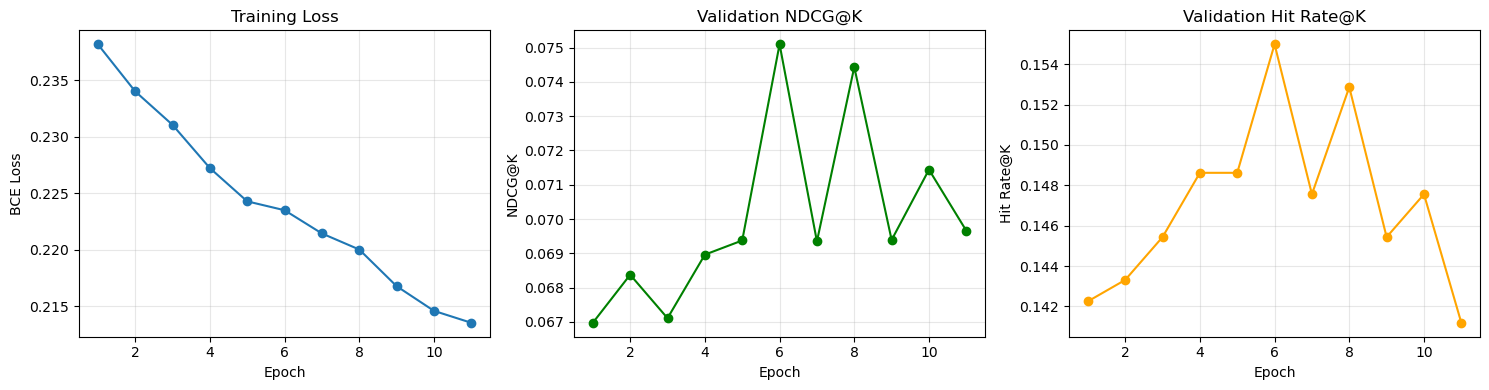

In [43]:
# Plot training history
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(history_df["epoch"], history_df["loss"], marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE Loss")
axes[0].set_title("Training Loss")
axes[0].grid(True, alpha=0.3)

# NDCG curve
axes[1].plot(history_df["epoch"], history_df["NDCG@K"], marker="o", color="green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("NDCG@K")
axes[1].set_title("Validation NDCG@K")
axes[1].grid(True, alpha=0.3)

# Hit Rate curve
axes[2].plot(history_df["epoch"], history_df["HitRate@K"], marker="o", color="orange")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Hit Rate@K")
axes[2].set_title("Validation Hit Rate@K")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()